#  Author: Priyanka Prusty

# Imports

In [41]:
#All imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.externals import joblib
import pickle

# Load Data

In [44]:
#Load the Dataset in to df_train
df_train = pd.read_csv('dataset.csv')

# Preprocessing

## Missing Values Detection

In [45]:
#missing data in the dataset
number_of_missingdata = df_train.isnull().sum().sort_values(ascending=False)
percent_of_missingdata = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([number_of_missingdata, percent_of_missingdata], axis=1, 
                         keys=['Number_of_missingdata', 'Percent_of_missingdata'])
print(missing_data.head(20))

print("*"*50)

#total number of missing data
total=df_train.isnull().sum().sum()
print('Total missing data=',total)


#I found no missing data in the dataset, hence I am getting 0 missing datas.




                 Number_of_missingdata  Percent_of_missingdata
Exited                               0                     0.0
EstimatedSalary                      0                     0.0
IsActiveMember                       0                     0.0
HasCrCard                            0                     0.0
NumOfProducts                        0                     0.0
Balance                              0                     0.0
Tenure                               0                     0.0
Age                                  0                     0.0
Gender                               0                     0.0
Geography                            0                     0.0
CreditScore                          0                     0.0
Surname                              0                     0.0
CustomerId                           0                     0.0
**************************************************
Total missing data= 0


## Drop irrelevant columns

In [46]:
df_train= df_train.drop(['Surname','CustomerId'],axis=1)

## Handling catagorical variables

In [47]:

target = 'Exited'


#number of catagorical variables
categorical_variables = df_train.dtypes[df_train.dtypes == "object"].index
catg_list=df_train[categorical_variables]
numerical_variables = df_train.dtypes[df_train.dtypes != "object"].index

print("Number of Categorical features: ", len(categorical_variables))
print("*"*50)
print(catg_list.head(3))
print("*"*50)   


#introduce dummy variables    
df_train = pd.get_dummies(df_train,categorical_variables)

        
#copy encoded data frame in to data_frame for testing later models
data_frame=df_train.copy(deep=True)

Number of Categorical features:  2
**************************************************
  Geography  Gender
0     Spain    Male
1    France  Female
2   Germany  Female
**************************************************


In [48]:
df_train.shape

(9000, 14)

## Select Relevant Features from Corelation Matrix

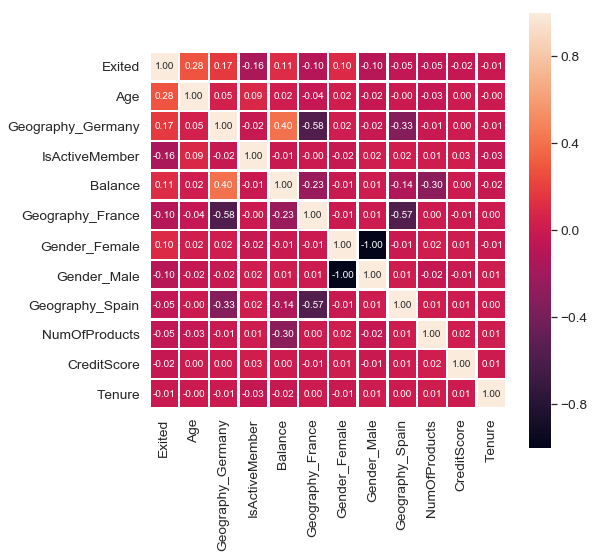

Final list of selected features:
['Exited', 'Age', 'Geography_Germany', 'IsActiveMember', 'Balance', 'Geography_France', 'Gender_Female', 'Gender_Male', 'Geography_Spain', 'NumOfProducts', 'CreditScore', 'Tenure']


In [49]:
#plot heatmap
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()
    

#set the threshold for feature selection
corr_theshold=.009

#find the correlation values
corr = df_train.corr()
corr_abs = corr.abs()

num_cols = len(df_train.columns)
#sort the correlation values in descending order
sort_corr = corr_abs.nlargest(num_cols, target)[target]
#print(sort_corr)

#filter the features with above correlation values
cols_abv_corr_limit = list(sort_corr[sort_corr.values > corr_theshold].index)
cols_bel_corr_limit = list(sort_corr[sort_corr.values <= corr_theshold].index)
selected_feats=cols_abv_corr_limit
nr_feats = len(cols_abv_corr_limit)

#plot the heatmap with selected features
plot_corr_matrix(df_train, nr_feats, target)

#drop the features from df_train with correaltion value below threshold
for df in [df_train]:
    df.drop(cols_bel_corr_limit, inplace=True, axis=1)

print("Final list of selected features:")
print(selected_feats)



In [50]:
df_train.shape

(9000, 12)

# 80-20 split (training and test)

In [51]:
#Split data set and reindex all of them for better concatnation
def splitAndReindex(X, y,test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
    y_train.reset_index(drop=True, inplace=True)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    return X_train, X_test, y_train, y_test


#Call the above function
y = df_train.Exited
X = df_train.drop('Exited', axis=1)
X_train, X_test, y_train, y_test = splitAndReindex(X,y)
print('Shape of X_train',X_train.shape)
print('Shape of X_test',X_test.shape)

Shape of X_train (7200, 11)
Shape of X_test (1800, 11)


# Standardization

In [52]:
#Normalize using StandardScalar
scaler = StandardScaler()
#apply normalization on traing data
X_train_norm = scaler.fit_transform(X_train)
#apply normalization on test data with traing data statistics
X_test_norm = scaler.transform(X_test)

# Design an artificial neural network, ANN using Keras library. 

In [53]:
'''
11x10 - ReLU, 10x5 - ReLU, 5x4 - ReLU, 5x1 - Sigmoid,
Epoch=100,
Optimizer= adam, 
loss = binary_crossentropy
'''
ann_model = Sequential([
    Dense(10, activation='relu', input_shape=(11,)),
    Dense(5, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid'),
])

ann_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model on Training Set

In [54]:
#Train the ann_model with X_train data
hist = ann_model.fit(X_train_norm, y_train, epochs=100, verbose=0)

#Evaluate trained model on Training data and get the accuracy
accuracy = ann_model.evaluate(X_train_norm, y_train, verbose=0)[1]

#Predict the classes to evaluate Presicion, F1-Score and Recall score
y_pred_train = ann_model.predict_classes(X_train_norm)
print('Train precision score = ', precision_score(y_train, y_pred_train , average="binary"))
print('Train recall score = ', recall_score(y_train, y_pred_train , average="binary"))
print('Train f1 score = ', f1_score(y_train, y_pred_train , average="binary"))
print('Train accuracy = ',accuracy)


Train precision score =  0.7719298245614035
Train recall score =  0.5144429160935351
Train f1 score =  0.617416425918283
Train accuracy =  0.87125


# Apply the model on Test Set

In [55]:
#Predict the classes for Test data to evaluate Presicion, F1-Score, Recall score and accuracy
y_pred_test = ann_model.predict_classes(X_test_norm)
print('Test precision score = ', precision_score(y_test, y_pred_test , average="binary"))
print('Test recall score = ', recall_score(y_test, y_pred_test , average="binary"))
print('Test f1 score = ', f1_score(y_test, y_pred_test , average="binary"))
print('Test accuracy = ',accuracy_score(y_test, y_pred_test))


Test precision score =  0.7215189873417721
Test recall score =  0.4535809018567639
Test f1 score =  0.5570032573289901
Test accuracy =  0.8488888888888889


In [56]:
y_pred_test

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

# Model Evaluation Helper Class

In [17]:
class ModelEvaluationHelper:

    def __init__(self, data_frame, correlation_threshold, scaling, scaling_type,  layers, 
                 optimizer, n_epoch, description):
        '''
        This method initializes various parameters of the classes
        :param data_frame: The data frame with categorical data already handled
        :param correlation_threshold: The threshold for which the feature will be selected
        :param scaling: True/False whether to apply scaling
        :param scalingType: MinMaxScaler or StandardScaler
        :param layers: The arrray of layer configuration for keras model
        :param optimizer: The optimizer to be used for training
        :param n_epoch: The number of times the optimizer will run
        :param description: A short description of model and other parameter
        '''
        self.data_frame = data_frame
        self.layers = layers
        self.optimizer = optimizer
        self.scaling = scaling
        self.scaling_type = scaling_type
        self.n_epoch = n_epoch
        self.train_accuracy = 0
        self.train_precision_score = 0
        self.train_recall_score = 0
        self.train_f1_score = 0
        self.test_accuracy = 0
        self.test_precision_score = 0
        self.test_recall_score = 0
        self.test_f1_score = 0
        self.corr_theshold = correlation_threshold
        self.description = description
        self.select_features()
        self.split_train_test_and_reindex()
        self.standardize_data()
        self.evaluate_model()


    def select_features(self):
        print('------- Starting feature selection ---------- ')
        target = 'Exited'
        corr = self.data_frame.corr()
        corr_abs = corr.abs()
        num_cols = len(self.data_frame.columns)
        print('Number of columns in existing data frame : ',num_cols)
        # sort the correlation values in descending order
        sort_corr = corr_abs.nlargest(num_cols, target)[target]
        # print(sort_corr)

        # filter the features with above correlation values
        cols_abv_corr_limit = list(sort_corr[sort_corr.values > self.corr_theshold].index)
        cols_bel_corr_limit = list(sort_corr[sort_corr.values <= self.corr_theshold].index)
        self.selected_feats = cols_abv_corr_limit

        # drop the features from data_frame with correaltion value below threshold
        for df in [self.data_frame]:
            df.drop(cols_bel_corr_limit, inplace=True, axis=1)
        print("Final list of selected features: ", self.selected_feats)
        print('------- Done feature selection ---------- ')

    def split_train_test_and_reindex(self):
        print('------- Starting Train/Test split ---------- ')
        y = self.data_frame.Exited
        X = self.data_frame.drop('Exited', axis=1)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2)
        self.y_train.reset_index(drop=True, inplace=True)
        self.X_train.reset_index(drop=True, inplace=True)
        self.X_test.reset_index(drop=True, inplace=True)
        self.y_test.reset_index(drop=True, inplace=True)
        print('------- Done Train/Test split ---------- ')

    def standardize_data(self):
        print('------- Starting Data Standardization/Normalization ---------- ')
        if self.scaling:
            if(self.scaling_type == 'MinMaxScaler'):
                scaler = MinMaxScaler()
            else:
                scaler = StandardScaler()
            self.X_train_input = scaler.fit_transform(self.X_train)
            self.X_test_input = scaler.transform(self.X_test)
            self.scaler = scaler
        else:
            self.X_train_input = self.X_train
            self.X_test_input = self.X_test
        print('------- Done Data Standardization/Normalization ---------- ')

    '''
    This method does the following
    1. Create the model
    2. Train it using the training data
    3. Find evaluation parameters for both train and test data
    '''
    def evaluate_model(self):
        print('------- Starting Model Building and Training ---------- ')
        ann_model = Sequential(self.layers)
        ann_model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        ann_model.fit(self.X_train_input, self.y_train, epochs=self.n_epoch, verbose=0)
        self.ann_model = ann_model
        print('------- Done Model Building and Training ---------- ')

        print('------- Starting Model Evaluation ---------- ')
        y_train_pred = self.ann_model.predict_classes(self.X_train_input)
        self.train_accuracy = self.ann_model.evaluate(self.X_train_input, self.y_train, verbose=0)[1]
        self.train_precision_score = precision_score(self.y_train, y_train_pred, average="binary")
        self.train_recall_score = recall_score(self.y_train, y_train_pred, average="binary")
        self.train_f1_score = f1_score(self.y_train, y_train_pred, average="binary")

        y_test_pred = self.ann_model.predict_classes(self.X_test_input)
        self.test_accuracy = accuracy_score(self.y_test, y_test_pred)
        self.test_precision_score = precision_score(self.y_test, y_test_pred, average="binary")
        self.test_recall_score = recall_score(self.y_test, y_test_pred, average="binary")
        self.test_f1_score = f1_score(self.y_test, y_test_pred, average="binary")

        self.print_stats()
        print('------- Done Model Evaluation ---------- ')
        
    
    
    '''
    This method is highly crucial for using the saved model and other trained 
    data to use in the test_code jupyter notebook.
    This method saves various trained objects to file.
    '''            
    def save_model(self):
        #Save the ANN Model
        self.ann_model.save('kerasModel.h5')
        #Save the fitted scaler object
        if(self.scaling):
            joblib.dump(self.scaler, 'scaler.pkl')
        #Save the selected features
        with open('selected_features.txt', 'w') as filehandle:
            for listitem in self.selected_feats:
                filehandle.write('%s\n' % listitem)

    '''
    This method prints the train and the test score for the model
    '''
    def print_stats(self):
        print('Train precision score = ', self.train_precision_score)
        print('Train recall score = ', self.train_recall_score)
        print('Train f1 score = ', self.train_f1_score)
        print('Train accuracy = ', self.train_accuracy)

        print('Test precision score = ', self.test_precision_score)
        print('Test recall score = ', self.test_recall_score)
        print('Test f1 score = ', self.test_f1_score)
        print('Test accuracy = ', self.test_accuracy)
   
    '''
    This method generates text for the preparing a CSV file for the report.
    It basically reports 
    Configuration, Accuracy(train, test), Precision(train, test), 
    Recall(Train, Test), F1 Score (train, test)
    It generate a comma separated row for the CSV file which I would use it
    in the report.
    '''
    def get_report(self):
        sb = []
        sb.append(self.description)
        sb.append(',')
        sb.append(str(self.train_accuracy))
        sb.append(',')
        sb.append(str(self.test_accuracy))
        sb.append(',')
        sb.append(str(self.train_precision_score))
        sb.append(',')
        sb.append(str(self.test_precision_score))
        sb.append(',')
        sb.append(str(self.train_recall_score))
        sb.append(',')
        sb.append(str(self.test_recall_score))
        sb.append(',')
        sb.append(str(self.train_f1_score))
        sb.append(',')
        sb.append(str(self.test_f1_score))
        return ''.join(sb)
        

In [18]:
model_evaluation_list = []

# Design multiple artificial neural network, ANN using Keras library. 

## ANN -1

In [19]:
model_1 = ModelEvaluationHelper(data_frame=data_frame.copy(deep=True), correlation_threshold=0.009, scaling=True,
   scaling_type='StandardScaler',
   layers=[Dense(10, activation='relu', input_shape=(11,)),
           Dense(5, activation='relu'), Dense(4, activation='relu'),
           Dense(1, activation='sigmoid'), ], optimizer='adam',
   n_epoch=100,
   description='(11x10-ReLU;10x5-ReLU;5x4-ReLU;4x1-Sigmoid;)Epoch=100;Optimizer=adam;loss=binary_crossentropy;scaling=True;scaler=StandardScaler;correlation_threshold=0.009')


------- Starting feature selection ---------- 
Number of columns in existing data frame :  14
Final list of selected features:  ['Exited', 'Age', 'Geography_Germany', 'IsActiveMember', 'Balance', 'Geography_France', 'Gender_Female', 'Gender_Male', 'Geography_Spain', 'NumOfProducts', 'CreditScore', 'Tenure']
------- Done feature selection ---------- 
------- Starting Train/Test split ---------- 
------- Done Train/Test split ---------- 
------- Starting Data Standardization/Normalization ---------- 
------- Done Data Standardization/Normalization ---------- 
------- Starting Model Building and Training ---------- 
------- Done Model Building and Training ---------- 
------- Starting Model Evaluation ---------- 
Train precision score =  0.7527200791295747
Train recall score =  0.5107382550335571
Train f1 score =  0.6085565773690524
Train accuracy =  0.8640277777777777
Test precision score =  0.686046511627907
Test recall score =  0.5190615835777126
Test f1 score =  0.5909849749582637
Tes

In [20]:
model_evaluation_list.append(model_1)

## ANN -2

In [ ]:
model_2=ModelEvaluationHelper(data_frame=data_frame.copy(deep=True), correlation_threshold=0.006, scaling=True,
   scaling_type='StandardScaler',
   layers=[Dense(11, activation='relu', input_shape=(12,)),
           Dense(9, activation='relu'), Dense(7, activation='relu'),
           Dense(5, activation='sigmoid'),Dense(3, activation='sigmoid'),
           Dense(1, activation='sigmoid')], optimizer='adam',
   n_epoch=100,
   description='(12x11-ReLU;11x9-ReLU;9x7-ReLU;7x5-Sigmoid;5x3-Sigmoid;3x1-Sigmoid);Epoch=100;Optimizer=adam;loss=binary_crossentropy;scaling=True;scaler=StandardScaler;correlation_threshold=0.006')


In [ ]:
model_evaluation_list.append(model_2)

## ANN -3

In [ ]:
model_3=ModelEvaluationHelper(data_frame=data_frame.copy(deep=True), correlation_threshold=0.006, scaling=True,
   scaling_type='StandardScaler',
   layers=[Dense(11, activation='relu', input_shape=(12,)),
           Dense(9, activation='relu'), Dense(7, activation='relu'),
           Dense(5, activation='relu'),Dense(3, activation='sigmoid'),
           Dense(1, activation='sigmoid')], optimizer='adam',
   n_epoch=1000,
   description='(12x11-ReLU;11x9-ReLU;9x7-ReLU;7x5-ReLU;5x3-Sigmoid;3x1-Sigmoid);Epoch=100;Optimizer=adam;loss=binary_crossentropy;scaling=True;scaler=StandardScaler;correlation_threshold=0.006')

In [ ]:
model_evaluation_list.append(model_3)

## ANN -4 

In [ ]:
model_4 = ModelEvaluationHelper(data_frame=data_frame.copy(deep=True), correlation_threshold=0.01, scaling=True,
   scaling_type='StandardScaler',
   layers=[Dense(10, activation='relu', input_shape=(11,)),
           Dense(5, activation='relu'), Dense(4, activation='relu'),
           Dense(1, activation='sigmoid'), ], optimizer='adam',
   n_epoch=100,
   description='(11x10-ReLU;10x5-ReLU;5x4-ReLU;4x1-Sigmoid);Epoch=100;Optimizer=adam;loss=binary_crossentropy;scaling=True;scaler=StandardScaler;correlation_threshold=0.01')

In [ ]:
model_evaluation_list.append(model_4)

## ANN -5

In [ ]:
model_5=ModelEvaluationHelper(data_frame=data_frame.copy(deep=True), correlation_threshold=0.006, scaling=True,
   scaling_type='StandardScalar',
   layers=[Dense(11, activation='relu', input_shape=(12,)),
           Dense(9, activation='relu'), Dense(7, activation='relu'),
           Dense(5, activation='sigmoid'),Dense(2, activation='sigmoid'),
           Dense(1, activation='sigmoid')], optimizer='adam',
   n_epoch=100,
   description='(12x11-ReLU;11x9-ReLU;9x7-ReLU;7x5-Sigmoid;5x2-Sigmoid;2x1-Sigmoid);Epoch=100;Optimizer=adam;loss=binary_crossentropy;scaling=True;scaler=StandardScaler;correlation_threshold=0.006')

In [ ]:
model_evaluation_list.append(model_5)

## ANN -6

In [ ]:
model_6 = ModelEvaluationHelper(data_frame=data_frame.copy(deep=True), correlation_threshold=0.01, scaling=True,
   scaling_type='StandardScaler',
   layers=[Dense(10, activation='relu', input_shape=(11,)),
           Dense(5, activation='relu'), Dense(4, activation='relu'),
           Dense(1, activation='sigmoid'), ], optimizer='sgd',
   n_epoch=100,
   description='(11x10-ReLU;10x5-ReLU;5x4-ReLU;4x1-Sigmoid);Epoch=100;Optimizer=sgd;loss=binary_crossentropy;scaling=True;scaler=StandardScaler;correlation_threshold=0.01')

In [ ]:
model_evaluation_list.append(model_6)

## ANN -7

In [ ]:
model_7 = ModelEvaluationHelper(data_frame=data_frame.copy(deep=True), correlation_threshold=0.01, scaling=True,
   scaling_type='MinMaxScaler',
   layers=[Dense(10, activation='relu', input_shape=(11,)),
           Dense(5, activation='relu'), Dense(4, activation='relu'),
           Dense(1, activation='sigmoid'), ], optimizer='sgd',
   n_epoch=100,
   description='(11x10-ReLU;10x5-ReLU;5x4-ReLU;4x1-Sigmoid);Epoch=100;Optimizer=sgd;loss=binary_crossentropy;scaling=True;scaler=MinMaxScaler;correlation_threshold=0.01')

In [ ]:
model_evaluation_list.append(model_7)

## ANN -8 

In [ ]:
model_8 = ModelEvaluationHelper(data_frame=data_frame.copy(deep=True), correlation_threshold=0.01, scaling=True,
   scaling_type='StandardScaler',
   layers=[Dense(10, activation='relu', input_shape=(11,)),
           Dense(5, activation='relu'), Dense(4, activation='relu'),
           Dense(1, activation='sigmoid'), ], optimizer='sgd',
   n_epoch=1000,
   description='(11x10-ReLU;10x5-ReLU;5x4-ReLU;4x1-Sigmoid);Epoch=1000;Optimizer=sgd;loss=binary_crossentropy;scaling=True;scaler=StandardScaler;correlation_threshold=0.01')

In [ ]:
model_evaluation_list.append(model_8)

## Choose the best ANN

In [21]:
print('Number of evaluated models : ',len(model_evaluation_list))

Number of evaluated models :  1


In [22]:
'''
We choose the ANN with best Test Accuracy
'''
best_test_accuracy = -1
best_model_index = -1
for index in range(len(model_evaluation_list)):
    if(best_test_accuracy < model_evaluation_list[index].test_accuracy) :
        best_test_accuracy = model_evaluation_list[index].test_accuracy
        best_model_index = index
print('Best model index: ', best_model_index)
print('Best model description: ', model_evaluation_list[best_model_index].description )
print('------ Best model stats ----')
model_evaluation_list[best_model_index].print_stats()

Best model index:  0
Best model description:  (11x10-ReLU;10x5-ReLU;5x4-ReLU;4x1-Sigmoid;)Epoch=100;Optimizer=adam;loss=binary_crossentropy;scaling=True;scaler=StandardScaler;correlation_threshold=0.009
------ Best model stats ----
Train precision score =  0.7527200791295747
Train recall score =  0.5107382550335571
Train f1 score =  0.6085565773690524
Train accuracy =  0.8640277777777777
Test precision score =  0.686046511627907
Test recall score =  0.5190615835777126
Test f1 score =  0.5909849749582637
Test accuracy =  0.8638888888888889


## Save the best ANN data for use in test_code for the Judge label prediction Jupyter Notebook

In [26]:
model_evaluation_list[best_model_index].save_model()

## Generate CSV data for preparing the Report

In [ ]:
for i in range(len(model_evaluation_list)):  
    print ('ANN-' + str(i+1) + ',' + model_evaluation_list[i].get_report())

In [63]:
df_judge = pd.read_csv('judge.csv')
#missing data in the dataset
number_of_missingdata = df_judge.isnull().sum().sort_values(ascending=False)
percent_of_missingdata = (df_judge.isnull().sum()/df_judge.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([number_of_missingdata, percent_of_missingdata], axis=1, 
                         keys=['Number_of_missingdata', 'Percent_of_missingdata'])
print(missing_data.head(20))

print("*"*50)

#total number of missing data
total=df_judge.isnull().sum().sum()
print('Total missing data=',total)
##Save customer id for later use to create final judge-pred.csv file
df_customerId = df_judge['CustomerId']
#Drop the irrelevant columns
df_judge= df_judge.drop(['Surname','CustomerId'],axis=1)

#number of catagorical variables
categorical_variables = df_judge.dtypes[df_judge.dtypes == "object"].index
catg_list=df_judge[categorical_variables]
numerical_variables = df_judge.dtypes[df_judge.dtypes != "object"].index

print("Number of Categorical features: ", len(categorical_variables))
print("*"*50)
print(catg_list.head(3))
print("*"*50)   


#introduce dummy variables    
df_judge = pd.get_dummies(df_judge,categorical_variables)
df_judge_final=df_judge.filter(df_train.columns)

X_judge = scaler.transform(df_judge_final)
y_judge = ann_model.predict_classes(X_judge)
customerId_list = df_customerId.values.tolist()
file_handler = open('judge-pred10.csv','w')
file_handler.write('CustomerID,Exited\n')
for i in range (0, len(y_judge)):
    file_handler.write('%d,%d\n' %(customerId_list[i], y_judge[i]))
file_handler.close()

                 Number_of_missingdata  Percent_of_missingdata
EstimatedSalary                      0                     0.0
IsActiveMember                       0                     0.0
HasCrCard                            0                     0.0
NumOfProducts                        0                     0.0
Balance                              0                     0.0
Tenure                               0                     0.0
Age                                  0                     0.0
Gender                               0                     0.0
Geography                            0                     0.0
CreditScore                          0                     0.0
Surname                              0                     0.0
CustomerId                           0                     0.0
**************************************************
Total missing data= 0
Number of Categorical features:  2
**************************************************
  Geography  Gender
0 

In [64]:
y_judge

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
    